In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

### The Break Down of Work
- **Pranav Kumar Jain Rajesh Kumar:** Introduction, Motivation & Graphs on Regression Assumption, Multicollinearity, Heteroscedasticity, and Influential Points blog content, Python code
- **Xiangling(Monika) Liu:** MLR & The Model Selection Process blog content, Python code 
- **Samanvitha Chowdary Bayaneni:** Advanced topics discussion - HQC metric for model evaluation, polynomial models blog content, Python code
- **Yewon Park:** Deployment of blog post & model selection application on Streamlit

---

### Introduction
Selecting the right statistical model for a dataset can be a daunting task, particularly when faced with a wide range of options and evaluation criteria. With so many factors to consider—such as how well a model fits the data, whether its assumptions hold, and how it performs across different metrics—data scientists often struggle to make informed decisions efficiently. To address this, we developed a user-friendly tool that simplifies the model selection process.

Our platform enables users to upload datasets, specify input and target variables, and explore a variety of linear model combinations. The system then compares the user's selected model with the statistically optimal model, based on metrics such as Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), Adjusted R², Mallows’ Cp, and the Hannan-Quinn Criterion (HQC). In addition, it provides insights into model performance through error plots and diagnostic checks for issues like multicollinearity, giving users deeper understanding and confidence in their final model choices.

### Motivation
The primary motivation for developing this tool stems from the common frustrations encountered during the model selection process. In practical data analysis, choosing the right model is crucial not only for accuracy but also for ensuring interpretability and reliability. Yet, many practitioners, especially those new to data science or machine learning, struggle to navigate the maze of statistical evaluations and theoretical assumptions.

This challenge becomes particularly apparent when attempting to compare models based on different criteria, like AIC or BIC, and interpreting results while avoiding over-reliance on p-values. Moreover, understanding model diagnostics—such as whether assumptions like multicollinearity or homoskedasticity hold—requires significant expertise, which is often lacking or time-consuming to apply.

By automating model comparison and providing clear explanations of why one model may be better than another, we aim to lower the barrier to effective model selection. Additionally, visualizing key metrics and offering comprehensive diagnostic insights helps users learn and gain confidence in their choices, ultimately making the model selection process more transparent and accessible to both beginners and experienced data scientists alike.

---

### Model Selection Process

### Data

In [2]:
icecream = pd.read_csv('../data/IceCreamConsumption.csv')
icecream.head()

,cons,income,price,temp,time
0,0.386,78,0.270,41,1
1,0.374,79,0.282,56,2
2,0.393,81,0.277,63,3
3,0.425,80,0.280,68,4
4,0.406,76,0.272,69,5


For this data, our response variable is ice cream consumption and we have customer income, ice cream price, day temperature as the potential predictors. All of them are numeric variables. 

### Model Selection

Fit regression models for all possible combinations of predictors.

In [3]:
def best_subset_selection(X, y):
    n, p = X.shape
    models = []
    
    for k in range(1, p + 1):  # Iterate over subset sizes
        for combo in combinations(range(1, p), k):  # Generate combinations of predictors
            combo = (0,) + combo  # Include the intercept
            X_subset = X[:, combo]
            model = sm.OLS(y, X_subset).fit()
            models.append((model, combo))
    
    return models

Calculate Mallow's Cp.

In [4]:
def get_cp(sse_k, mse_p, num_params, n):
    return (sse_k / mse_p) + 2 * num_params - n

Calculate all the metrics except for Mallow's Cp (i.e. Adjusted R^2, AIC, BIC, PRESS).

In [5]:
def calculate_metrics(model, X, y):
    n = len(y)
    k = model.df_model  # Number of predictors, excluding intercept

    # AIC
    aic = model.aic
    
    # BIC
    bic = model.bic
    
    # PRESS (Prediction Sum of Squares)
    hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
    residuals = model.resid
    press = np.sum((residuals / (1 - np.diag(hat_matrix))) ** 2)
    
    # Adjusted R-squared
    r2 = model.rsquared
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    
    return aic, bic, press, adj_r2, int(k) #dont consider intercept as a predictor

Now, we compute these metrics for each of our model.

In [6]:
X = np.array(icecream.iloc[:, 1:-1])
X = sm.add_constant(X)
y = np.array(icecream.iloc[:, 0])
models = best_subset_selection(X, y)
full_model = sm.OLS(y, X).fit()
sse_full = full_model.ssr
n = len(y)
p_full = X.shape[1]
mse_full = sse_full / (n - p_full) 

results = []
for model, combo in models:
    predictors = []
    aic, bic, press, adj_r2, num_predictors = calculate_metrics(model, X[:, combo], y)
    for c in combo:
        if c != 0:
            predictors.append(icecream.columns[c])
    sse_k = model.ssr
    num_params = len(combo)
    cp = get_cp(sse_k, mse_full, num_params, n)   
    results.append({
        'Predictors': predictors,
        'n_Predictors': num_predictors,
        'Adjusted R^2': adj_r2,
        'Mallows Cp': cp,
        'AIC': aic,
        'BIC': bic,
        'PRESS': press
    })

Convert our results to a dataframe which includes all the metrics for each of the models.

In [7]:
# Convert results to pd DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='n_Predictors').reset_index(drop=True)
# Display our results
pd.set_option('display.max_columns', None)  # Show all columns
results_df #0 represents intercept – all models include intercept4

,Predictors,n_Predictors,Adjusted R^2,Mallows Cp,AIC,BIC,PRESS
0,[income],1,-0.033334,66.312063,-75.226523,-72.424129,0.143838
1,[price],1,0.034082,60.289517,-77.250524,-74.448130,0.137697
2,[temp],1,0.587365,10.862432,-102.765980,-99.963585,0.057693
3,"[income, price]",2,-0.001257,62.251945,-75.263590,-71.059997,0.147622
4,"[income, temp]",2,0.679989,3.566900,-109.483295,-105.279703,0.046441
5,"[price, temp]",2,0.605619,9.973407,-103.214426,-99.010834,0.059883
6,"[income, price, temp]",3,0.686570,4.000000,-109.238872,-103.634082,0.047845


Input this dataframe to the following function, we obtain a summary table that indicates the optimal model based on specific criteria. 

In [8]:
def get_model_summary(df):
    adj_r2_idx = df['Adjusted R^2'].idxmax()
    aic_idx = df['AIC'].idxmin()
    bic_idx = df['BIC'].idxmin()
    press_idx = df['PRESS'].idxmin()
    diff_ser = df['Mallows Cp'] - (df['n_Predictors']+1)[:-1] # excluding the full model
    mallowscp_idx = diff_ser.idxmin()
    results = {
        'Criteria': ['Adjusted R^2', 'Mallows Cp', 'AIC', 'BIC', 'PRESS'],
        'Suggested Model':[df.iloc[adj_r2_idx, 0], df.iloc[mallowscp_idx, 0], df.iloc[aic_idx, 0],
                           df.iloc[bic_idx, 0], df.iloc[press_idx, 0]]
    }
    return pd.DataFrame(results)

In [9]:
selected_model = get_model_summary(results_df)
selected_model

,Criteria,Suggested Model
0,Adjusted R^2,"[income, price, temp]"
1,Mallows Cp,"[income, temp]"
2,AIC,"[income, temp]"
3,BIC,"[income, temp]"
4,PRESS,"[income, temp]"


### Summary
- The full model has the highest Adjusted R-squared, so we choose it over other models since a higher Adjusted R-squared indicates better explanatory power.
- For Mallows' Cp, the ideal model is the one where Cp is closest to the number of parameters. Under this criterion, the cons ~ income + temp model is the best choice.
- For AIC, BIC, and PRESS, we seek the smallest values. Therefore, based on these criteria, the cons ~ income + temp model is the preferred option. 


### Model Selection Criteria Explained

- **Adjusted R-squared:**
  
  $$
  R^2_{\text{adj}} = 1 - \frac{\text{MSE}}{\text{MST}}
  $$

  Adjusted R-squared measures how much of the variability in the response variable is explained by the model, adjusting for the number of predictors. We aim for it to be as **large as possible**, indicating better explanatory power while avoiding overfitting.

- **Mallows' Cp:**

  $$
  C_p = \frac{\text{SSE}_p}{\text{MSE}_{\text{full}}} + 2p - n
  $$

  Mallows' Cp helps balance bias and variance. We want Cp to be **close to the number of parameters (P)**, which indicates a well-fitted model without unnecessary complexity.

- **AIC (Akaike Information Criterion):**

  $$
  \text{AIC} = n \cdot \log(2\pi) + n \cdot \log(\text{SSE}_p) - n \cdot \log(n) + 2p
  $$

  AIC assesses model fit while penalizing model complexity. **Lower AIC values** are preferred, indicating a better trade-off between fit and simplicity.

- **BIC (Bayesian Information Criterion):**

  $$
  \text{BIC} = n \cdot \log(2\pi) + n \cdot \log(\text{SSE}_p) - n \cdot \log(n) + (\log(n)) \cdot p
  $$

  Like AIC, BIC also penalizes complexity but more strictly. **Lower BIC values** indicate better model performance, particularly when avoiding overly complex models.

- **PRESS (Prediction Sum of Squares):**

  $$
  \text{PRESS} = \sum_{i=1}^{n} \left( \frac{e_i}{1 - h_{ii}} \right)^2
  $$

  PRESS measures how well the model predicts new data by calculating squared errors from leave-one-out predictions. **Lower PRESS values** are preferred, indicating better predictive accuracy.

In summary, an ideal model will have:
- **High Adjusted R-squared** for strong explanatory power,
- **Cp near the number of parameters (P)** for a balanced model,
- **Low AIC, BIC, and PRESS** to ensure the model is both accurate and not overly complex.



---

### Regression Diagnostics

In [10]:
def plot_qq(model):
    # Plots the QQ-Plot
    qq_plot = ProbPlot(model.resid)
    fig, ax = plt.subplots(figsize=(8.5, 6))

    # Plot the Q-Q plot with customized markers and quartile line for proper visualization
    qq_plot.qqplot(ax=ax, line='q', markerfacecolor='blue', markeredgewidth=1, marker='o', alpha=0.7)

    # Set plot title and axis labels
    ax.set_title('Q-Q Plot of Residuals', fontsize=14)
    ax.set_xlabel('Theoretical Quantiles', fontsize=12)
    ax.set_ylabel('Sample Quantiles', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_residual_histogram(residuals):
    # Plots a histogram of residuals.
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

def plot_correlation_matrix(X):
    # Plots the correlation matrix
    plt.figure(figsize=(10.8, 6))
    corr = X.corr()
    sns.heatmap(corr, annot=True, cmap='Blues', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_vif(X):
    # Plots VIF for each feature.
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data

def check_homoskedasticity(ols_model):
    # Extract fitted values and residuals
    fitted_values = ols_model.fittedvalues
    residuals = ols_model.resid
    sqrt_abs_residuals = np.sqrt(np.abs(residuals))  # Square root of absolute residuals

    # Set up the figure
    plt.figure(figsize=(16, 6))

    # Plot: Residuals vs. Fitted Values
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=fitted_values, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # Show plots
    plt.tight_layout()
    plt.show()

def check_influential_points(ols_model):
    # Extract leverage, Cook's distance
    influence = ols_model.get_influence()
    leverage = influence.hat_matrix_diag  # Leverage values
    cooks_d = influence.cooks_distance[0]  # Cook's distance
    
    influence_df = pd.DataFrame({
        'Leverage': leverage,
        'Cooks_Distance': cooks_d
    })

    # Identify influential points based on Cook's Distance
    n = len(ols_model.model.endog)
    threshold_cooks = 4 / n
    influential_points = influence_df[influence_df['Cooks_Distance'] > threshold_cooks]

    # Plot Leverage vs. Cook's Distance
    plt.figure(figsize=(21.5, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(leverage, cooks_d)
    plt.axhline(threshold_cooks, color='red', linestyle='--', label='Cook\'s Distance Threshold')
    plt.xlabel('Leverage')
    plt.ylabel('Cook\'s Distance')
    plt.title('Leverage vs. Cook\'s Distance')
    plt.legend()

In [11]:
# Fit the model
X = icecream[['income', 'price', 'temp']]
y = icecream['cons']

X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()

# Get residuals
residuals = model.resid

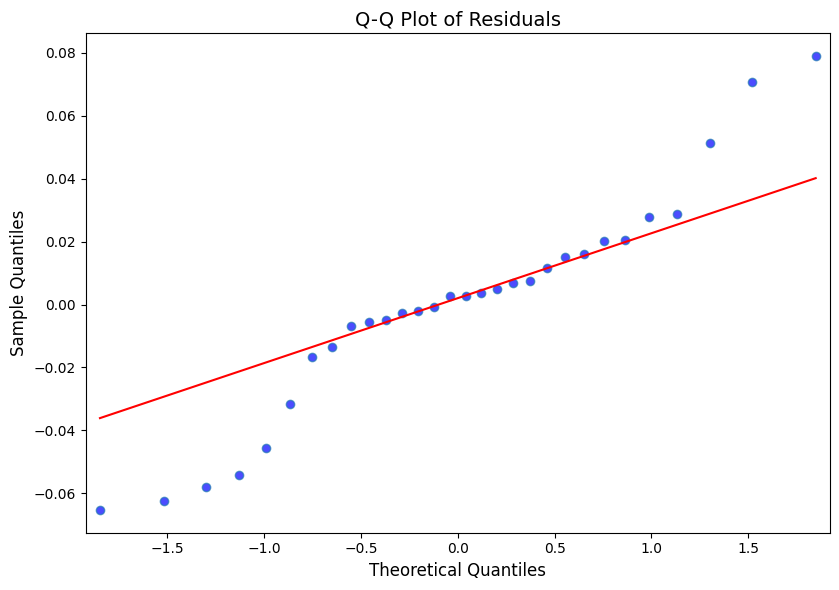

In [12]:
# Q-Q Plot of Residuals
plot_qq(model)

### Q-Q Plot of Residuals:

**Purpose**: The Q-Q (quantile-quantile) plot compares the distribution of the model's residuals to a normal distribution.

**Interpretation**:
- If the points closely follow the diagonal line, the residuals are approximately normally distributed, which is a key assumption of linear regression.
- Deviations from this line, especially in the tails, may indicate issues such as non-normality of residuals, which can affect hypothesis testing and confidence intervals.

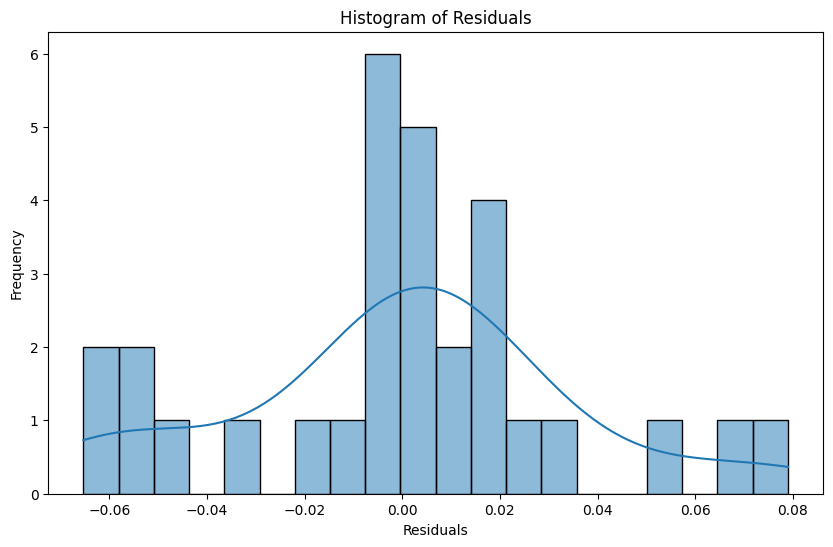

In [13]:
# Histogram of Residuals
plot_residual_histogram(residuals)

### Histogram of Residuals:

**Purpose**: This plot shows the frequency distribution of the residuals.

**Interpretation**:
- A bell-shaped histogram suggests that the residuals are normally distributed, supporting the assumption of linear regression.
- If the histogram is skewed or has multiple peaks, it may indicate non-normality, which could violate regression assumptions.

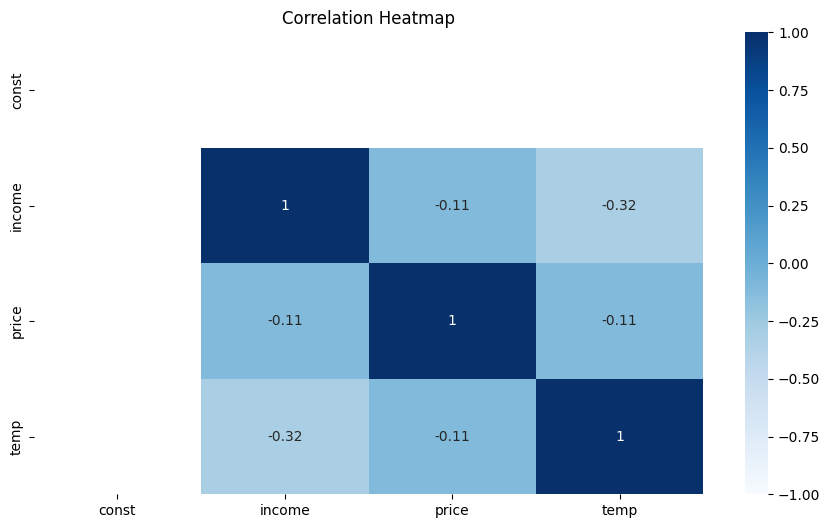

In [14]:
# Correlation Matrix
plot_correlation_matrix(X)

### Correlation Matrix:

**Purpose**: The correlation matrix provides insights into the relationships between independent variables.

**Interpretation**:
- Values close to +1 or -1 indicate strong correlations, while values near 0 suggest weak correlations.
- High correlation between independent variables may suggest multicollinearity, which can inflate the variance of coefficient estimates and make the model unstable.

In [15]:
# Variance Inflation Factor (VIF)
vif = plot_vif(X)
print(vif)

  Feature          VIF
0   const  1614.644163
1  income     1.144186
2   price     1.035673
3    temp     1.144367


### Variance Inflation Factor (VIF):

**Purpose**: VIF measures how much the variance of a regression coefficient is increased due to multicollinearity.

**Interpretation**:
- A VIF value above 5 or 10 is often considered problematic, suggesting significant multicollinearity.
- High VIF values indicate that the predictor variable is highly correlated with other variables, which can distort the model’s performance.

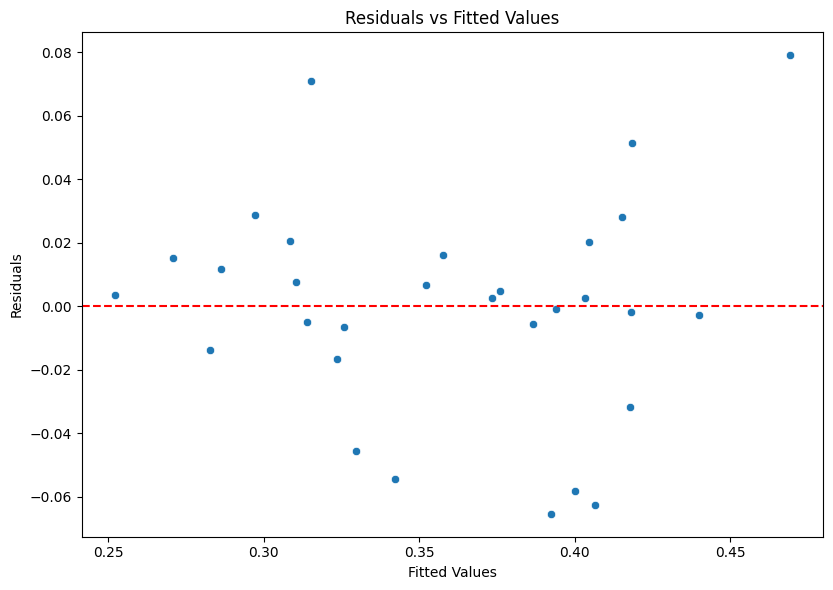

In [16]:
# Homoskedasticity
check_homoskedasticity(model)

### Homoskedasticity:

**Purpose**: This analysis checks whether the residuals exhibit constant variance across all levels of the independent variables.

**Interpretation**:
- If the residuals are randomly scattered around zero with no discernible pattern, homoskedasticity is satisfied, supporting the linear regression assumptions.
- Patterns in the residuals, such as funnels or curves, suggest heteroskedasticity (non-constant variance), which can lead to inefficient estimates and affect statistical tests.

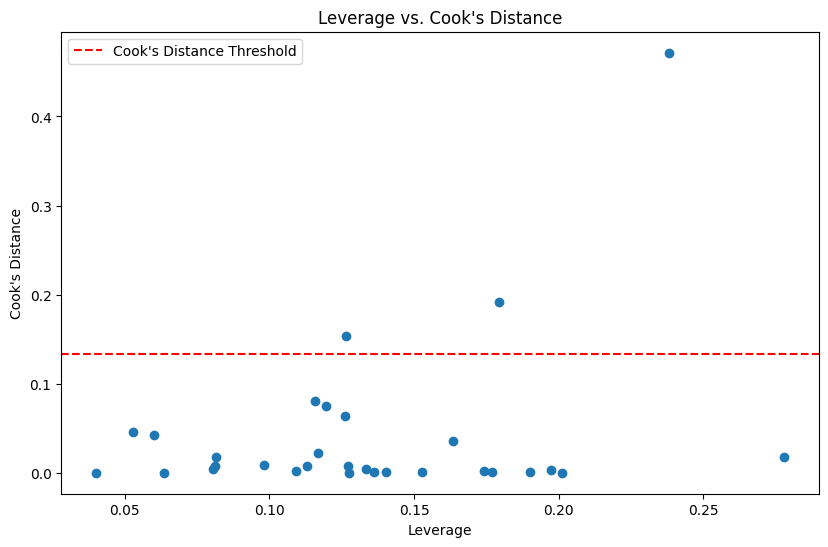

In [17]:
# Influential Points
check_influential_points(model)

### Influential Points:

**Purpose**: This analysis identifies observations that have a disproportionate impact on the regression model’s coefficients and predictions.

**Interpretation**:
- Points identified as influential may indicate outliers or leverage points that could skew the model results.
- It’s important to investigate these points further to understand their impact on the model and determine if they should be retained or excluded from analysis.


---

### Extension

### What is the Hannan-Quinn Criterion (HQC)?

As per the textbook, HQC is defined as

> The Hannan-Quinn Criterion (HQC) is a statistical criterion used for model selection in regression analysis. It is designed to assess the goodness-of-fit of a model while penalizing for model complexity, helping to prevent overfitting.


$$
\boldsymbol{HQC} = \boldsymbol{n} \cdot \ln\left(\frac{\boldsymbol{RSS}}{\boldsymbol{n}}\right) + 2 \cdot \boldsymbol{k} \cdot \ln(\ln(\boldsymbol{n}))
$$


<!-- <center><img src="https://i.imgur.com/hVtjA0A.png" height=200 width=300></center> -->

Where:

- n is the number of observations.
- k is Indicates the number of estimated parameters in the model (including the intercept).
- RSS is the residual sum of squares that result from the model.

As per our understanding, HQC is defined as

> HQC, much like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion), is used to evaluate the model and handle the complexity of a model by applying a penalty to the likelihood function based on the number of parameters, helping to prevent overfitting by discouraging overly complex models.

#### Key Points About HQC:

- **Logarithmic Transformation:** The criterion uses natural logarithms to transform ratio of RSS to number of observations, which helps in normalizing the measure.
- **Penalty for Complexity:** The term `2×𝑘×ln(ln(𝑛))` acts as a penalty for model complexity, discouraging the use of too many parameters. The logarithmic nature of the penalty allows it to grow at a rate that is less severe than that of BIC, making HQC a moderate choice.

#### Difference from AIC and BIC:
- AIC uses a penalty of `2×k`, meaning it penalizes complexity less than HQC and BIC.
- BIC uses `k×ln(n)`, which gives a stronger penalty for model complexity than HQC.
- HQC’s penalty term `2×k×ln(ln(n))` grows more slowly than BIC but faster than AIC, making it a middle ground between the two.

#### What Makes HQC Interesting

1. **Asymptotic Properties:**
   - HQC has favorable asymptotic properties, meaning that as the sample size increases, it tends to select the correct model more reliably than AIC, making it appealing in larger datasets.

2. **Flexibility in Application:**
   - HQC can be used for various types of models beyond linear regression, such as nonlinear and time series models, enhancing its versatility in different statistical contexts.

3. **Focus on Predictive Accuracy:**
   - The primary goal of HQC is to improve predictive accuracy. By balancing model complexity and goodness of fit, it aids in developing models that generalize well to new data.

### Practical Example

In [18]:
y = icecream['cons']

predictors = ['income', 'price', 'temp']
combinations = []

for i in range(1, len(predictors) + 1):
    combinations += list(itertools.combinations(predictors, i))

X_full = sm.add_constant(icecream[['income', 'price', 'temp']])
y = icecream[['cons']]
full_model = sm.OLS(y, X_full).fit()

def calculate_cp(model, X, y):
    n = len(y)
    p = full_model.df_model +1 # number of parameters in the full model
    k = model.df_model # number of predictors in the reduced model 
    sse_p = model.ssr
    mse_f = full_model.ssr/(n-p)
    cp = (sse_p / mse_f) - n + ((2 * k) + 2)
    return cp

def calculate_metrics(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    n = len(y)
    k = model.df_model + 1  
    
    aic = model.aic
    bic = model.bic
    adj_r2 = model.rsquared_adj
    log_likelihood = model.llf
    hqc = -2 * log_likelihood + 2 * k * np.log(np.log(n))
    cp = calculate_cp(model, X, y)
    
    influence = model.get_influence()
    residuals = model.resid
    hat_matrix = X.values @ np.linalg.inv(X.values.T @ X) @ X.values.T
    press = np.sum((residuals / (1 - np.diag(hat_matrix))) ** 2)
    
    return aic, bic, cp, adj_r2, press, hqc

results = []

for combo in combinations:
    X = icecream[list(combo)]
    aic, bic, cp, adj_r2, press, hqc = calculate_metrics(X, y)
    results.append({
        'Model': ' + '.join(combo),
        'AIC': aic,
        'BIC': bic,
        'Cp': cp,
        'Adjusted R²': adj_r2,
        'PRESS': press,
        'HQC': hqc
    })

results_df = pd.DataFrame(results)
results_df

,Model,AIC,BIC,Cp,Adjusted R²,PRESS,HQC
0,income,-75.226523,-72.424129,66.312063,-0.033334,0.143838,-74.330013
1,price,-77.250524,-74.448130,60.289517,0.034082,0.137697,-76.354014
2,temp,-102.765980,-99.963585,10.862432,0.587365,0.057693,-101.869470
3,income + price,-75.263590,-71.059997,62.251945,-0.001257,0.147622,-73.918824
4,income + temp,-109.483295,-105.279703,3.566900,0.679989,0.046441,-108.138530
5,price + temp,-103.214426,-99.010834,9.973407,0.605619,0.059883,-101.869660
6,income + price + temp,-109.238872,-103.634082,4.000000,0.686570,0.047845,-107.445852


1. **AIC (Akaike Information Criterion)**: Best model is `income + temp` (AIC = -109.48)

2. **BIC (Bayesian Information Criterion)**: Best model is `income + temp` (BIC = -105.28)

#### Interpreting HQC:

Lower HQC values are better.
   - **Best model**: `income + temp` (HQC = -108.14)
   - **Next best**: `income + price + temp` (HQC = -107.45)

Even HQC picked the `income + temp` model as it has the lowest HQC, slightly better than `income + price + temp`.

**Note:**

- **Comparison with AIC/BIC:** HQC lies between AIC and BIC in terms of model selection. For example, if your HQC value is lower than the AIC or BIC values, it suggests that HQC finds a better balance between fit and complexity.
- **Model Selection:** If you are comparing multiple models, you should select the one with the lowest HQC value, as it balances goodness of fit and model complexity.
- **Large Sample Sizes:** For large datasets, BIC may over-penalize complexity, leading to an overly simplistic model. In such cases, HQC provides a more reasonable penalty for complexity without selecting too simple a model.

#### When to Use HQC:
- **Large Datasets:** HQC is better suited for large datasets where the number of parameters grows slowly relative to the number of observations. In such cases, the slower-growing penalty term in HQC prevents over-penalizing the model, which could happen with BIC.
- **Balancing Simplicity and Complexity:** HQC finds a middle ground between AIC (which tends to overfit) and BIC (which tends to underfit). If you find that AIC suggests overly complex models and BIC suggests overly simple ones, HQC might strike a better balance.

#### Drawbacks of HQC

1. **Complexity in Interpretation:**
   - The criteria can be complex to interpret, especially for those new to statistical modeling. It may require a solid understanding of the underlying theory to apply effectively.

2. **Sensitivity to Sample Size:**
   - HQC is sensitive to the sample size; smaller datasets might not provide reliable estimates, leading to misleading conclusions. As sample size increases, the criterion becomes more reliable, but small samples can skew results.

3. **Overfitting Risk:**
   - Like other information criteria (AIC, BIC), HQC can still select overly complex models that overfit the data, particularly if the penalty for additional parameters isn't sufficient to discourage unnecessary complexity.

4. **Comparative Use:**
   - HQC is primarily useful for comparing models rather than providing an absolute measure of model quality. It can indicate which model is better among a set, but it does not inherently indicate how good any individual model is.

5. **Assumption of Normality:**
   - The criterion assumes that the errors are normally distributed, which may not always hold in practice. If this assumption is violated, it could lead to inaccurate model selection.

> HQC is an excellent alternative to AIC and BIC, particularly useful when AIC tends to overfit, and BIC tends to underfit. By applying HQC in combination with AIC and BIC, you can make better-informed decisions regarding model selection.

### References

- https://support.numxl.com/hc/en-us/articles/215531183-Appendix-E-Hannan-Quinn-Information-Criterion-HQC
- https://en.wikipedia.org/wiki/Hannan%E2%80%93Quinn_information_criterion

### What are Polynomial Models?

As per the textbook:
> Polynomial models are defined as statistical models where the relationship between the dependent variable and the independent variable(s) is expressed as a polynomial equation. For example, a polynomial regression model of degree \(n\) can be represented as:
$$
y = \boldsymbol{\beta_0} + \boldsymbol{\beta_1} x + \boldsymbol{\beta_2} x^2 + \cdots + \boldsymbol{\beta_n} x^n + \boldsymbol{\epsilon}
$$

where \(y\) is the dependent variable, \(x\) is the independent variable, \(beta_0, beta_1, ..., beta_n\) are the coefficients, and \(epsilon\) is the error term.

As per our understanding:
> Polynomial models extend from linear regression by including curvilinear relationships among the variables. Squares and cubes of the independent variables are included, among higher-order terms, to facilitate even more complex learning of the patterns in the data.

### Difference from Single Power Models
- **Form**: Single power models use a straight-line equation $y = \boldsymbol{\beta_0} + \boldsymbol{\beta_1} x $, while polynomial models can include squared or higher-order terms $ y = \boldsymbol{\beta_0} + \boldsymbol{\beta_1} x + \boldsymbol{\beta_2} x^2 $.
- **Fit**: Linear models assume a constant rate of change, whereas polynomial models can adapt to varying rates of change, allowing for curves in the data.
- **Complexity**: Linear models are generally simpler and easier to interpret, while polynomial models can become complex as the degree increases.

#### What Makes Polynomial Models Interesting

##### 1. **Local Behavior Control**
   - The degree of the polynomial allows analysts to control the curvature of the fit. For example, a quadratic model may be sufficient for data with a single curve, while a cubic model can accommodate more intricate patterns.
   - Polynomials can exhibit local maxima and minima, which can be valuable in understanding the dynamics of the data, such as identifying peaks in marketing response curves or other phenomena.

##### 2. **Modeling Seasonal and Cyclical Patterns**
   - In time series data, polynomial models can effectively capture cyclical patterns and trends over time, such as seasonal fluctuations, by including time as a predictor variable raised to various powers.

##### 3. **Data Smoothing**
   - Polynomial regression can be used to smooth out noisy data points, providing a clearer view of underlying trends without overfitting, especially when choosing an appropriate degree.

### Practical Example

In [19]:
np.random.seed(42)
n = 100
X = np.linspace(0, 10, n)
y = 2 * X**2 + 3 * X + 5 + np.random.normal(0, 10, n)  # Quadratic relationship with noise

data = pd.DataFrame({'X': X, 'y': y})

data['X2'] = data['X']**2
data['X3'] = data['X']**3

X_full = sm.add_constant(data[['X', 'X2', 'X3']])
y_full = data['y']

full_model = sm.OLS(y_full, X_full).fit()

models = [
    ['X'],          
    ['X', 'X2'],    
    ['X', 'X2', 'X3']  
]

results = []

for model in models:
    X = data[model]
    aic, bic, cp, adj_r2, press, hqc = calculate_metrics(X, y_full)
    results.append({
        'Model': ' + '.join(model),
        'AIC': aic,
        'BIC': bic,
        'Cp': cp,
        'Adjusted R²': adj_r2,
        'PRESS': press,
        'HQC': hqc
    })

results_df = pd.DataFrame(results)
results_df

,Model,AIC,BIC,Cp,Adjusted R²,PRESS,HQC
0,X,867.594433,872.804773,313.754129,0.931773,34675.114772,869.703151
1,X + X2,729.454436,737.269947,6.902765,0.983026,8575.856733,732.617514
2,X + X2 + X3,726.473523,736.894203,4.000000,0.983682,8297.851715,730.690960


#### Comparison by Metrics

1. **X + X² + X³** has the lowest **AIC** with **726.473523**.

2. **X + X² + X³** has the lowest **BIC** with **736.89420**.

3. **X + X² + X³** has **Cp** closest to parameters with **4.0**.

4. **X + X² + X³** has the highest **Adjusted R²** with **0.983682**.

5. **X + X² + X³** has the lowest **PRESS** with **8297.851715**.

6. **X + X² + X³** has the lowest **HQC** with **730.690960**.

**Note**
- X + X² is very close in performance to X + X² + X³ across most metrics, especially BIC, PRESS, and HQC. 
- The very slight increase in Adjusted R² and small decreases in AIC and PRESS for X + X² + X³ suggest that while the cubic term provides a marginally better fit, it doesn't add much value in explaining the data.

> While X + X² + X³ technically performs better, X + X² is almost as good in terms of all the important metrics, which makes it a more parsimonious choice with very little loss in performance.

#### Why the Single Power Model (X) Performs Poorly:
- The model with just X shows *crazy* values for Cp and PRESS because a simple linear term cannot capture the true non-linear relationship in the data. As a result, metrics like Cp and PRESS explode, indicating that the model is underfitting. The model can't adequately explain the variability, which causes inflated errors and poor predictive power.
  
- Real-world data often has non-linear patterns, and restricting the model to just X fails to account for these complexities. This is why introducing higher-order terms (like X² and X³) dramatically improves the model fit and predictive performance. A single power model (just X) is insufficient for such data because it oversimplifies the relationship between the predictor and the response.

### When to Use Polynomials
- **Non-linear Relationships**: When data suggests that the relationship between the independent and dependent variables is not linear, polynomial models can be a good fit.
- **Curvilinear Trends**: In cases where trends appear to have curvature (e.g., U-shaped or inverted U-shaped), polynomial regression can capture these shapes effectively.
- **Data Patterns**: When exploratory data analysis reveals non-linear patterns, applying polynomial terms can enhance model accuracy.
- **Feature Expansion**: Polynomial models can be beneficial in feature engineering, transforming existing features into polynomial terms to improve model performance.

#### Drawbacks of Polynomial Models

1. **Overfitting:**
   - Polynomial models can easily overfit the data, especially with higher-degree polynomials. They may fit the training data perfectly but perform poorly on unseen data, as they capture noise instead of the underlying trend.

2. **Extrapolation Issues:**
   - Polynomial models can behave erratically outside the range of the training data. Extrapolating predictions based on polynomial functions can lead to unrealistic and highly variable results.

3. **Multicollinearity:**
   - Polynomial terms (e.g., \(x^2\), \(x^3\)) can introduce multicollinearity, leading to inflated standard errors for the coefficients and making it difficult to determine the individual effect of each predictor.


> Polynomial models are powerful tools for modeling complex relationships between variables. They provide greater flexibility than linear models, but careful consideration must be taken regarding the degree of the polynomial used to avoid overfitting and multicollinearity issues.

### What Other Metrics Can We Use to Evaluate a Model?

When it comes to evaluating the performance of regression models, relying solely on discussed metrics can sometimes lead to a limited understanding of how well your model is performing. Different metrics capture different aspects of model accuracy and robustness, allowing us to better assess how well our models predict outcomes. 

In this exploration, we also explored a little bit of two other significant metrics: Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE).

#### Mean Absolute Error (MAE)

**What is it**: Mean Absolute Error (MAE) is the average of the absolute differences between the predicted and actual values. It quantifies the magnitude of errors in a set of predictions, providing a straightforward measure of model accuracy.

**Formula**:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

Where:

- y_i is the actual value.
- y_hatis the predicted value.
- n is the total number of observations.

**Interpretation**:
- MAE is expressed in the same units as the response variable, making it intuitive and easy to interpret. For example, if you are predicting house prices, an MAE of 5,000 dollars means, on average, your predictions are off by 5,000 dollars.
- This metric is particularly useful when you want to provide a simple summary of prediction errors without overly penalizing larger discrepancies. Thus, MAE is robust to outliers compared to other metrics, such as RMSE, which emphasizes larger errors due to squaring.

**When to Use**:
- MAE is especially beneficial in applications where precision is important, such as budgeting or inventory management, where stakeholders need to understand the average error in straightforward terms.
- Additionally, it is valuable in settings where the data might contain outliers or extreme values that could disproportionately influence other metrics.

#### Mean Absolute Percentage Error (MAPE)

**What is it?**: Mean Absolute Percentage Error (MAPE) measures the average absolute percentage error between predicted and actual values. This metric expresses the error in relative terms, making it easier to compare performance across different datasets or scales.

**Formula**:
$$
\
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
\
$$

Where:

- y_i is the actual value.
- y_hatis the predicted value.
- n is the total number of observations.

**Interpretation**:
- MAPE is expressed as a percentage, providing an intuitive understanding of the accuracy of predictions relative to actual values. For instance, a MAPE of 10% indicates that, on average, the predictions deviate from the actual values by 10%.
- It is particularly useful when you want to convey errors in a way that stakeholders can easily comprehend, as it normalizes the error against the magnitude of the actual values.

**When to Use**:
- MAPE is commonly used in business settings, such as sales forecasting or demand prediction, where stakeholders are interested in understanding performance relative to the scale of sales or demand.
- It is important to note that MAPE is best suited for datasets where the actual values are always positive, as the percentage calculation can yield undefined results when actual values are zero.

#### Practical Example

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

np.random.seed(42)

n = 5000
X = np.linspace(0, 10, n)  
y = 3 * X + 7 + np.random.normal(0, 2, n)  

df = pd.DataFrame({'X': X, 'y': y})

X_train, X_test, y_train, y_test = train_test_split(df[['X']], df['y'], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100 

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 1.5538603880374313
Mean Absolute Percentage Error (MAPE): 9.48%


1. **Mean Absolute Error (MAE): 1.55**

   The MAE value of **1.55** indicates that, on average, the predicted values deviate from the actual values by approximately **1.55 units**. This means that, in terms of the scale of the response variable `y`, our predictions are off by about 1.55 units on average. Lower MAE values are preferred, as they indicate better model performance in absolute terms. 

   - **Example interpretation**: If `y` represents some quantity like sales in units, then the predicted sales values are off by about 1.55 units from the actual sales on average. Depending on the context and scale of `y`, this could be considered a small or large error.

2. **Mean Absolute Percentage Error (MAPE): 9.48%**

   The MAPE value of **9.48%** means that, on average, the predictions are about **9.48% off** from the actual values. MAPE provides a relative measure of error, which is particularly useful when the range of the response variable is wide or when you need to compare the model’s performance across datasets with different scales.

   - **Example interpretation**: If `y` represents some sales figures (e.g., dollars, units sold), then the model's predictions are approximately **9.48% less accurate** compared to the actual values. A MAPE of less than 10% is generally considered a reasonably accurate model, so this result suggests that the model is doing fairly well in predicting `y`.

> Both Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) provide valuable insights into model performance, each with its strengths and weaknesses. MAE offers a clear understanding of average errors in the same units as the predictions, making it easy to interpret. MAPE, on the other hand, provides a relative perspective on prediction accuracy, facilitating comparisons across different scales.